## Importing Libraries and Datasets

In [1]:
import pandas as pd     
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
%matplotlib inline

import random
import os

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import callbacks

In [2]:
#Trying to get reproducible results
from numpy.random import seed
seed(42)
from tensorflow.random import set_seed
set_seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)

In [3]:
df_train = pd.read_csv('../input/tabular-playground-series-jun-2021/train.csv', index_col = 'id')
Y_train = df_train['target'].copy()
X_train = df_train.copy().drop('target', axis = 1)
X_test = pd.read_csv('../input/tabular-playground-series-jun-2021/test.csv', index_col = 'id')

In [4]:
class_map = {'Class_1': 0,
            'Class_2': 1,
            'Class_3': 2,
            'Class_4': 3,
            'Class_5': 4,
            'Class_6': 5,
            'Class_7': 6,
            'Class_8': 7,
            'Class_9': 8}
Y_train = Y_train.map(class_map).astype('int')
Y_train

id
0         5
1         5
2         1
3         7
4         1
         ..
199995    5
199996    5
199997    7
199998    6
199999    7
Name: target, Length: 200000, dtype: int64

In [5]:
#Converting target series to matrix for multiclass classification on Keras

Y_train = to_categorical(Y_train)
Y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

## Creating and Evaluating the Wide and Deep NN

In [6]:
def get_wideanddeep():
    # Wide Network
    wide = keras.experimental.LinearModel()

    # Deep Network
    inputs = keras.Input(shape=[75])
    x = layers.Embedding(360, 8, input_length = 75)(inputs)
    x = layers.Conv1D(16, kernel_size=1, activation='relu')(x) #added 21/06
    x = layers.Flatten()(x)
    x = layers.Dropout(0.3)(x) #added 21/06
    x = layers.Dense(units = 128, activation = 'relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(units = 64, activation = 'relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(units = 32, activation = 'relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    #outputs = layers.Dense(9, activation = 'softmax')(x)
    outputs = layers.Dense(9)(x)
    deep = keras.Model(inputs=inputs, outputs=outputs)
    
    # Wide and Deep Network
    wide_and_deep = keras.experimental.WideDeepModel(
        linear_model=wide,
        dnn_model=deep,
        activation='softmax',
    )
    
    return wide_and_deep

In [7]:
keras.backend.clear_session()

wide_and_deep_model = get_wideanddeep()
wide_and_deep_model.compile(loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=0.0002), metrics='accuracy')

In [8]:
X_train_split, X_val_split, Y_train_split, Y_val_split = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 42
                                                    , stratify = Y_train)

In [9]:
early_stopping = callbacks.EarlyStopping(
    patience=15,
    min_delta=0.0000001,
    restore_best_weights=True,
)

#New callback
plateau = callbacks.ReduceLROnPlateau(
    factor = 0.5,                                     
    patience = 2,                                   
    min_delt = 0.0000001,                                
    cooldown = 0,                               
    verbose = 1
) 

In [10]:
history = wide_and_deep_model.fit(X_train_split, Y_train_split,                   
          batch_size = 128, epochs = 100,
          validation_data=(X_val_split, Y_val_split),
          callbacks=[early_stopping, plateau]);

Epoch 1/100
1250/1250 [==============================] - 11s 5ms/step - loss: 2.3996 - accuracy: 0.2112 - val_loss: 1.8194 - val_accuracy: 0.3569
Epoch 2/100
1250/1250 [==============================] - 6s 5ms/step - loss: 1.8774 - accuracy: 0.3296 - val_loss: 1.7609 - val_accuracy: 0.3603
Epoch 3/100
1250/1250 [==============================] - 6s 5ms/step - loss: 1.8015 - accuracy: 0.3472 - val_loss: 1.7545 - val_accuracy: 0.3618
Epoch 4/100
1250/1250 [==============================] - 7s 5ms/step - loss: 1.7803 - accuracy: 0.3522 - val_loss: 1.7512 - val_accuracy: 0.3615
Epoch 5/100
1250/1250 [==============================] - 6s 5ms/step - loss: 1.7734 - accuracy: 0.3540 - val_loss: 1.7529 - val_accuracy: 0.3598
Epoch 6/100
1250/1250 [==============================] - 6s 5ms/step - loss: 1.7703 - accuracy: 0.3529 - val_loss: 1.7491 - val_accuracy: 0.3615
Epoch 7/100
1250/1250 [==============================] - 6s 5ms/step - loss: 1.7612 - accuracy: 0.3572 - val_loss: 1.7486 - val_a

In [11]:
score = wide_and_deep_model.evaluate(X_val_split, Y_val_split, verbose = 0)
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}%'.format(score[1] * 100))

Test loss: 1.7467145919799805
Test accuracy: 36.28250062465668%


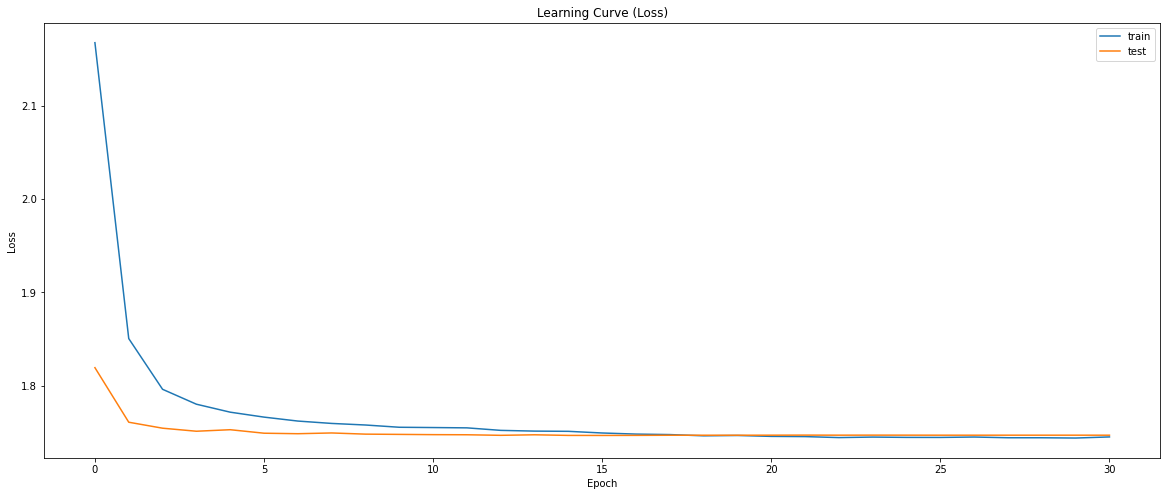

In [12]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['train', 'test'], loc='best')
plt.show()

## Making Predictions

In [13]:
Y_train = df_train['target'].copy()
Y_train = Y_train.map(class_map).astype('int')
Y_train

id
0         5
1         5
2         1
3         7
4         1
         ..
199995    5
199996    5
199997    7
199998    6
199999    7
Name: target, Length: 200000, dtype: int64

In [14]:
def prediction (X_train, Y_train, X_test):
    
    keras.backend.clear_session()

    kfold = StratifiedKFold(n_splits = 25)

    y_pred = np.zeros((100000,9))
    train_oof = np.zeros((200000,9))
    
    for idx in kfold.split(X=X_train, y=Y_train):
        train_idx, val_idx = idx[0], idx[1]
        xtrain = X_train.iloc[train_idx]
        ytrain = Y_train.iloc[train_idx]
        xval = X_train.iloc[val_idx]
        yval = Y_train.iloc[val_idx]
        
        ytrain = to_categorical(ytrain)
        yval = to_categorical(yval)
        
        # fit model for current fold
        wide_and_deep_model = get_wideanddeep()
        wide_and_deep_model.compile(loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=0.0002), metrics='accuracy')
        
        wide_and_deep_model.fit(xtrain, ytrain,
        batch_size = 128, epochs = 100,
        validation_data=(xval, yval),
        callbacks=[early_stopping, plateau]);

        #create predictions
        y_pred += wide_and_deep_model.predict(X_test)/kfold.n_splits
        print(y_pred)
               
        val_pred = wide_and_deep_model.predict(xval)
        # getting out-of-fold predictions on training set
        train_oof[val_idx] = val_pred
        
        # calculate and append logloss
        fold_logloss = metrics.log_loss(yval,val_pred)
        print("Logloss: {0:0.5f}". format(fold_logloss))
  
    return y_pred, train_oof

In [15]:
nn_pred, train_oof = prediction (X_train, Y_train, X_test)

Epoch 1/100
1500/1500 [==============================] - 8s 5ms/step - loss: 2.3950 - accuracy: 0.2249 - val_loss: 1.7914 - val_accuracy: 0.3525
Epoch 2/100
1500/1500 [==============================] - 7s 4ms/step - loss: 1.8492 - accuracy: 0.3349 - val_loss: 1.7529 - val_accuracy: 0.3601
Epoch 3/100
1500/1500 [==============================] - 6s 4ms/step - loss: 1.7933 - accuracy: 0.3491 - val_loss: 1.7491 - val_accuracy: 0.3598
Epoch 4/100
1500/1500 [==============================] - 7s 5ms/step - loss: 1.7783 - accuracy: 0.3527 - val_loss: 1.7475 - val_accuracy: 0.3605
Epoch 5/100
1500/1500 [==============================] - 6s 4ms/step - loss: 1.7683 - accuracy: 0.3574 - val_loss: 1.7490 - val_accuracy: 0.3591
Epoch 6/100
1500/1500 [==============================] - 7s 4ms/step - loss: 1.7600 - accuracy: 0.3592 - val_loss: 1.7486 - val_accuracy: 0.3581

Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
Epoch 7/100
1500/1500 [==========================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1500/1500 [==============================] - 7s 5ms/step - loss: 1.7447 - accuracy: 0.3636 - val_loss: 1.7497 - val_accuracy: 0.3577

Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
Epoch 25/100
1500/1500 [==============================] - 7s 5ms/step - loss: 1.7453 - accuracy: 0.3641 - val_loss: 1.7497 - val_accuracy: 0.3573
Epoch 26/100
1500/1500 [==============================] - 6s 4ms/step - loss: 1.7445 - accuracy: 0.3641 - val_loss: 1.7497 - val_accuracy: 0.3571

Epoch 00026: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.
Epoch 27/100
1500/1500 [==============================] - 7s 4ms/step - loss: 1.7470 - accuracy: 0.3642 - val_loss: 1.7497 - val_accuracy: 0.3570
[[0.05094859 0.33190156 0.12920744 ... 0.01724987 0.03553454 0.0994939 ]
 [0.03499963 0.04901632 0.03973689 ... 0.07070757 0.25191822 0.10214995]
 [0.0146192  0.01911846 0.01289388 ... 0.0182364  0.08276553 0.03240843]
 ...
 [0.04562539 0.18502459 0.10126004 ... 0.0415

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1500/1500 [==============================] - 7s 4ms/step - loss: 1.7432 - accuracy: 0.3640 - val_loss: 1.7353 - val_accuracy: 0.3641
Epoch 31/100
1500/1500 [==============================] - 7s 5ms/step - loss: 1.7506 - accuracy: 0.3622 - val_loss: 1.7353 - val_accuracy: 0.3643

Epoch 00031: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.
Epoch 32/100
1500/1500 [==============================] - 7s 5ms/step - loss: 1.7448 - accuracy: 0.3638 - val_loss: 1.7354 - val_accuracy: 0.3649
Epoch 33/100
1500/1500 [==============================] - 7s 4ms/step - loss: 1.7479 - accuracy: 0.3627 - val_loss: 1.7353 - val_accuracy: 0.3640

Epoch 00033: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.
Epoch 34/100
1500/1500 [==============================] - 7s 4ms/step - loss: 1.7488 - accuracy: 0.3617 - val_loss: 1.7355 - val_accuracy: 0.3647
Epoch 35/100
1500/1500 [==============================] - 7s 5ms/step - loss: 1.7464 - accuracy: 0.3601 - val_loss: 1.7354

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1500/1500 [==============================] - 7s 4ms/step - loss: 1.7470 - accuracy: 0.3632 - val_loss: 1.7478 - val_accuracy: 0.3610
[[0.0563662  0.36440033 0.14215032 ... 0.01902249 0.03907217 0.10952622]
 [0.03853353 0.05423631 0.04393861 ... 0.07778921 0.2758651  0.11262983]
 [0.01608691 0.02122794 0.01429362 ... 0.02012437 0.09096558 0.03592742]
 ...
 [0.05016784 0.203499   0.11145187 ... 0.04576589 0.11713625 0.14238273]
 [0.03123622 0.02173324 0.01929833 ... 0.07304005 0.33349496 0.07750954]
 [0.04158961 0.08168251 0.06283435 ... 0.07390564 0.2206966  0.12687863]]
Logloss: 1.74669
Epoch 1/100
1500/1500 [==============================] - 8s 5ms/step - loss: 2.3274 - accuracy: 0.2194 - val_loss: 1.7923 - val_accuracy: 0.3661
Epoch 2/100
1500/1500 [==============================] - 7s 4ms/step - loss: 1.8478 - accuracy: 0.3344 - val_loss: 1.7475 - val_accuracy: 0.3708
Epoch 3/100
1500/1500 [==============================] - 7s 4ms/step - loss: 1.7920 - accuracy: 0.3461 - val_loss: 1

In [16]:
print("Logloss: {0:0.6f}".format(metrics.log_loss(Y_train,train_oof)))
#10 folds - Logloss: 1.744198

Logloss: 1.742429


In [17]:
train_oof = pd.DataFrame(train_oof, columns = ['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6', 'Class_7', 'Class_8', 'Class_9'])
train_oof

,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,0.013138,0.016654,0.010073,0.005021,0.002380,0.822062,0.017013,0.084409,0.029252
1,0.028262,0.086573,0.053934,0.014021,0.005970,0.554876,0.034900,0.129713,0.091750
2,0.049328,0.098643,0.074622,0.028713,0.020412,0.164242,0.097278,0.313202,0.153561
3,0.054119,0.114563,0.084527,0.031580,0.023065,0.114002,0.099741,0.317676,0.160727
4,0.063916,0.289851,0.145289,0.033122,0.018039,0.152968,0.042628,0.098629,0.155558
...,...,...,...,...,...,...,...,...,...
199995,0.045294,0.073763,0.061028,0.025580,0.017640,0.254750,0.090388,0.291198,0.140359
199996,0.040188,0.089291,0.069572,0.022853,0.015051,0.285341,0.077601,0.255882,0.144222
199997,0.043908,0.049405,0.042699,0.019793,0.015914,0.275616,0.093599,0.335370,0.123697
199998,0.042330,0.087449,0.071807,0.025666,0.018192,0.277381,0.080868,0.252885,0.143422


In [18]:
pred_test = pd.DataFrame(nn_pred, columns = ['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6', 'Class_7', 'Class_8', 'Class_9'])
pred_test

,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,0.064030,0.413015,0.161189,0.027990,0.013462,0.129054,0.021747,0.044753,0.124760
1,0.043682,0.062037,0.050250,0.021710,0.015264,0.277101,0.088422,0.313055,0.128479
2,0.018182,0.023768,0.016040,0.007913,0.004050,0.764054,0.022781,0.102723,0.040487
3,0.048610,0.134867,0.092336,0.030470,0.018496,0.227544,0.075415,0.213077,0.159183
4,0.044383,0.113068,0.081460,0.026674,0.016311,0.275291,0.072400,0.221608,0.148808
...,...,...,...,...,...,...,...,...,...
99995,0.063865,0.353068,0.161613,0.032219,0.016906,0.102752,0.037230,0.081725,0.150623
99996,0.056481,0.244369,0.134149,0.031802,0.017032,0.151330,0.055064,0.142823,0.166952
99997,0.057022,0.232362,0.126704,0.031464,0.016926,0.189808,0.051743,0.132504,0.161468
99998,0.035199,0.024506,0.021681,0.012528,0.009446,0.346928,0.082728,0.379444,0.087539


In [19]:
train_oof.to_csv('nn_train_oof.csv', index=False)
train_oof

,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,0.013138,0.016654,0.010073,0.005021,0.002380,0.822062,0.017013,0.084409,0.029252
1,0.028262,0.086573,0.053934,0.014021,0.005970,0.554876,0.034900,0.129713,0.091750
2,0.049328,0.098643,0.074622,0.028713,0.020412,0.164242,0.097278,0.313202,0.153561
3,0.054119,0.114563,0.084527,0.031580,0.023065,0.114002,0.099741,0.317676,0.160727
4,0.063916,0.289851,0.145289,0.033122,0.018039,0.152968,0.042628,0.098629,0.155558
...,...,...,...,...,...,...,...,...,...
199995,0.045294,0.073763,0.061028,0.025580,0.017640,0.254750,0.090388,0.291198,0.140359
199996,0.040188,0.089291,0.069572,0.022853,0.015051,0.285341,0.077601,0.255882,0.144222
199997,0.043908,0.049405,0.042699,0.019793,0.015914,0.275616,0.093599,0.335370,0.123697
199998,0.042330,0.087449,0.071807,0.025666,0.018192,0.277381,0.080868,0.252885,0.143422


In [20]:
output = pred_test
output['id'] = X_test.index
output.to_csv('submission.csv', index=False)